# Machine Learning
---

Entrenar un nuevo modelo (que no sea Random Forest ni el utilizado para el baseline) con búsqueda de hiperparametros (¿cómo conviene elegir los datos de validación respecto de los de train?). El modelo debe cumplir las siguientes condiciones:

* Deben utilizar AUC-ROC como métrica de validación.
* Deben medirse solo en validación, no contra test!!!
* Deben ser reproducibles (correr el notebook varias veces no afecta al resultado).
* Deben tener un score en validación superior a 0,9.
* Para el feature engineering debe utilizarse imputación de nulos, mean encoding y one hot encoding al menos una vez cada uno.
* Deben utilizar al menos 40 features (contando cómo features columnas con números, pueden venir varios de la misma variable).
* Deberán contestar la siguientes preguntas:
    - ¿Cuál es el score en test? (guardar el csv con predicciones para entregarlo después)
    - ¿Por qué cree que logro/no logro el mismo valor de AUC que con Random Forest?

In [1]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from feature_engine.encoding import MeanEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data/secondary_data.csv', sep=';')
df

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61064,p,1.18,s,s,y,f,f,f,f,3.93,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,a
61065,p,1.27,f,s,y,f,f,f,f,3.18,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,a
61066,p,1.27,s,s,y,f,f,f,f,3.86,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,u
61067,p,1.24,f,s,y,f,f,f,f,3.56,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,u


In [3]:
X = df.drop(['class'], axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [4]:
# Imputo los valores nulos.
si = SimpleImputer(strategy='most_frequent')
X_train = pd.DataFrame(si.fit_transform(X_train), columns=df.columns[1:])
X_test = pd.DataFrame(si.transform(X_test), columns=df.columns[1:])

# Encodeo la variable target.
ohe = OneHotEncoder(drop='first')
y_train = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()[:,0]
y_test = ohe.transform(y_test.values.reshape(-1,1)).toarray()[:,0]

# Encodeo las variables categoricas.
ohe = OneHotEncoder()
season_enc = ohe.fit_transform(X_train[['season']]).todense()
season_enc_test = ohe.transform(X_test[['season']]).todense()

me = MeanEncoder()
X_train = me.fit_transform(X_train.drop('season', axis=1), y_train)
X_test = me.transform(X_test.drop('season', axis=1))

X_train = X_train.join(pd.DataFrame(season_enc))
X_test = X_test.join(pd.DataFrame(season_enc_test))

/home/vinki/.local/lib/python3.11/site-packages/feature_engine/encoding/base_encoder.py:257: UserWarning: During the encoding, NaN values were introduced in the feature(s) cap-diameter, stem-height, stem-width.
  warnings.warn(


In [5]:
X_train

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,...,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,0,1,2,3
0,0.511628,0.781223,0.829352,0.782636,0.560632,0.379227,0.575157,0.474320,0.509804,0.666667,...,0.555583,0.550021,0.537769,0.548743,0.547063,0.685949,0.0,0.0,1.0,0.0
1,0.693333,0.781223,0.572493,0.598599,0.560632,0.634315,0.575157,0.606600,0.761905,0.854167,...,0.555583,0.550021,0.537769,0.548743,0.547063,0.685949,1.0,0.0,0.0,0.0
2,0.511111,0.519831,0.572493,0.782636,0.560632,0.568796,0.575157,0.455706,0.400000,0.500000,...,0.555583,0.550021,0.537769,0.548743,0.547063,0.545578,1.0,0.0,0.0,0.0
3,0.539683,0.512250,0.572493,0.488169,0.560632,0.568796,0.575157,0.592022,0.406250,0.777778,...,0.555583,0.550021,0.537769,0.548743,0.547063,0.545578,1.0,0.0,0.0,0.0
4,0.692308,0.519831,0.572493,0.894332,0.531372,0.602273,0.575157,0.689736,0.517241,0.562500,...,0.555583,0.550021,0.537769,0.548743,0.547063,0.652390,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48850,0.487805,0.539121,0.600928,0.581932,0.560632,0.604956,0.604956,0.604956,0.527273,0.388889,...,0.555583,0.550021,0.537769,0.548743,0.547063,0.545578,1.0,0.0,0.0,0.0
48851,0.511111,0.403349,0.572493,0.488169,0.560632,0.634315,0.575157,0.455706,0.446809,0.258065,...,0.555583,0.550021,0.537769,0.548743,0.547063,0.545578,1.0,0.0,0.0,0.0
48852,0.444444,0.539121,0.572493,0.480802,0.531372,0.602273,0.575157,0.455706,0.612500,0.500000,...,0.555583,0.550021,0.537769,0.548743,0.547063,0.545578,1.0,0.0,0.0,0.0
48853,0.627907,0.519831,0.434033,0.894332,0.531372,0.565885,0.407878,0.630511,0.611111,0.526316,...,0.555583,0.550021,0.537769,0.548743,0.547063,0.545578,1.0,0.0,0.0,0.0


In [6]:
xg = xgb.XGBClassifier(objective='binary:logistic', random_state=123)
xg.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

In [7]:
cross_validate(xg, X_train, y_train, cv=5, scoring=['roc_auc'])

{'fit_time': array([1.26034999, 1.07479239, 1.05640388, 1.25936675, 1.3434515 ]),
 'score_time': array([0.00922251, 0.00878906, 0.0089469 , 0.00868559, 0.00859308]),
 'test_roc_auc': array([0.99997357, 0.99997962, 0.99997938, 0.99997455, 0.99998948])}

Text(45.25, 0.5, 'Real')

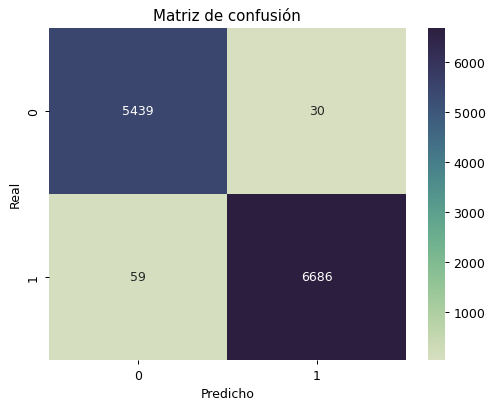

In [8]:
preds = xg.predict(X_test)
cm = confusion_matrix(y_test, preds)
plt.figure(dpi=90)
sns.heatmap(cm, annot=True, fmt='g', cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True))
plt.title('Matriz de confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')

In [12]:
features = pd.DataFrame({'features': df.columns[1:-1], 'importance': xg.feature_importances_[:-4]})
features.loc[len(features.index)] = ('season', xg.feature_importances_[-3:].sum())
features

,features,importance
0,cap-diameter,0.020153
1,cap-shape,0.034520
2,cap-surface,0.037037
3,cap-color,0.042416
4,does-bruise-or-bleed,0.037543
5,gill-attachment,0.034796
6,gill-spacing,0.054634
7,gill-color,0.033329
8,stem-height,0.047642
9,stem-width,0.126563


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'cap-diameter'),
  Text(1, 0, 'cap-shape'),
  Text(2, 0, 'cap-surface'),
  Text(3, 0, 'cap-color'),
  Text(4, 0, 'does-bruise-or-bleed'),
  Text(5, 0, 'gill-attachment'),
  Text(6, 0, 'gill-spacing'),
  Text(7, 0, 'gill-color'),
  Text(8, 0, 'stem-height'),
  Text(9, 0, 'stem-width'),
  Text(10, 0, 'stem-root'),
  Text(11, 0, 'stem-surface'),
  Text(12, 0, 'stem-color'),
  Text(13, 0, 'veil-type'),
  Text(14, 0, 'veil-color'),
  Text(15, 0, 'has-ring'),
  Text(16, 0, 'ring-type'),
  Text(17, 0, 'spore-print-color'),
  Text(18, 0, 'habitat'),
  Text(19, 0, 'season')])

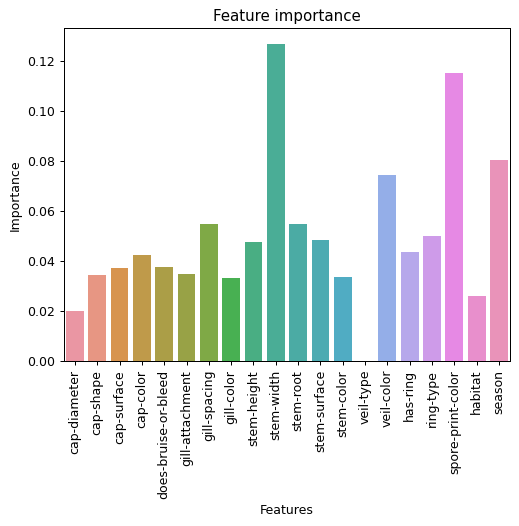

In [10]:
plt.figure(dpi=90)
sns.barplot(features, x='features', y='importance')
plt.title('Feature importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)